<a href="https://colab.research.google.com/github/ArchisKulkarni002/RansomwareMLProject/blob/main/Ransomware_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec  as gridspec
import matplotlib.ticker as mticker
import warnings
from IPython.display import display, HTML
import ipaddress

# Suppress all warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_seq_items', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Android_Ransomeware.csv'
ransomware_df = pd.read_csv(data_path)

#EDA and PreProcessing

In [35]:
#defining color palettes
ransomware_palette = sns.color_palette("Set1", 11)
protocol_palette = sns.color_palette("muted", 3)

In [5]:
ransomware_df.columns = ransomware_df.columns.str.strip()

In [6]:
print(ransomware_df.head(5))

   Index                                 Flow ID    Source IP  Source Port  Destination IP  Destination Port  Protocol         Timestamp  Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std   Flow Bytes/s  Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  CWE Flag Co

In [7]:
#printing shape of ransomware df
df_row_count, df_column_count = ransomware_df.shape
print("rows = ", df_row_count, " cols = ", df_column_count)

rows =  392034  cols =  86


In [8]:
def summarize_dataframe(df):
    # Initialize an empty list to store summary data for each column
    summary_data = []

    # Loop through each column to get dtype, null count, distinct count, and additional statistics
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        distinct_count = df[col].nunique()

        # Dictionary to store summary data for this column
        col_summary = {
            'Column': col.strip(),
            'Data Type': dtype,
            'Total Count': df_row_count,
            'Total Distinct': distinct_count,
            'Null Count': null_count

        }

        # Calculate stats based on data type
        if pd.api.types.is_numeric_dtype(df[col]):
            col_summary['Mean'] = df[col].mean()
            col_summary['Median'] = df[col].median()
            col_summary['Max'] = df[col].max()
            col_summary['Min'] = df[col].min()
            col_summary['Std_Dev'] = df[col].std()
        elif pd.api.types.is_object_dtype(df[col]):
            col_summary['Mode'] = df[col].mode().iloc[0] if not df[col].mode().empty else None
        else:
            col_summary['Mean'] = col_summary['Median'] = col_summary['Max'] = col_summary['Min'] = col_summary['Std_Dev'] = None
            col_summary['Mode'] = None

        # Append the column summary to the list
        summary_data.append(col_summary)

    return summary_data





In [9]:
summary_df = pd.DataFrame(summarize_dataframe(ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

,Column,Data Type,Total Count,Total Distinct,Null Count,Mean,Median,Max,Min,Std_Dev,Mode
0,Index,int64,392034,8699,0,1.872127e+03,1637.000000,8.698000e+03,0.000000e+00,1.441683e+03,NaN
1,Flow ID,object,392034,203556,0,NaN,NaN,NaN,NaN,NaN,8.0.6.4-8.6.0.1-0-0-0
2,Source IP,object,392034,2504,0,NaN,NaN,NaN,NaN,NaN,10.42.0.211
3,Source Port,int64,392034,52913,0,3.870163e+04,43469.000000,6.553400e+04,0.000000e+00,1.860661e+04,NaN
4,Destination IP,object,392034,5056,0,NaN,NaN,NaN,NaN,NaN,10.42.0.1
5,Destination Port,int64,392034,21942,0,5.941135e+03,443.000000,6.548700e+04,0.000000e+00,1.531961e+04,NaN
6,Protocol,int64,392034,3,0,8.373332e+00,6.000000,1.700000e+01,0.000000e+00,4.602725e+00,NaN
7,Timestamp,object,392034,4321,0,NaN,NaN,NaN,NaN,NaN,28-08-2017 12:10
8,Flow Duration,int64,392034,298031,0,1.067684e+07,515256.000000,1.199997e+08,1.000000e+00,2.197262e+07,NaN
9,Total Fwd Packets,int64,392034,605,0,7.078121e+00,2.000000,3.632000e+03,1.000000e+00,3.343450e+01,NaN


In [10]:
#Dropping the index columns
processed_ransomware_df = ransomware_df.drop(['Index', 'Flow ID' ], axis=1, inplace=False)

In [11]:
#columnns with only single value
single_valued_cols = summary_df.loc[summary_df['Total Distinct'] == 1, 'Column'].tolist()
print(single_valued_cols)

#Dropping the single valued columns
processed_ransomware_df = processed_ransomware_df.drop(single_valued_cols, axis=1, inplace=False)
summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'RST Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


,Column,Data Type,Total Count,Total Distinct,Null Count,Mode,Mean,Median,Max,Min,Std_Dev
0,Source IP,object,392034,2504,0,10.42.0.211,NaN,NaN,NaN,NaN,NaN
1,Source Port,int64,392034,52913,0,NaN,3.870163e+04,43469.000000,6.553400e+04,0.000000e+00,1.860661e+04
2,Destination IP,object,392034,5056,0,10.42.0.1,NaN,NaN,NaN,NaN,NaN
3,Destination Port,int64,392034,21942,0,NaN,5.941135e+03,443.000000,6.548700e+04,0.000000e+00,1.531961e+04
4,Protocol,int64,392034,3,0,NaN,8.373332e+00,6.000000,1.700000e+01,0.000000e+00,4.602725e+00
5,Timestamp,object,392034,4321,0,28-08-2017 12:10,NaN,NaN,NaN,NaN,NaN
6,Flow Duration,int64,392034,298031,0,NaN,1.067684e+07,515256.000000,1.199997e+08,1.000000e+00,2.197262e+07
7,Total Fwd Packets,int64,392034,605,0,NaN,7.078121e+00,2.000000,3.632000e+03,1.000000e+00,3.343450e+01
8,Total Backward Packets,int64,392034,943,0,NaN,8.711813e+00,1.000000,1.282000e+04,0.000000e+00,8.094987e+01
9,Total Length of Fwd Packets,int64,392034,10711,0,NaN,8.844412e+02,31.000000,4.309688e+06,0.000000e+00,1.662189e+04


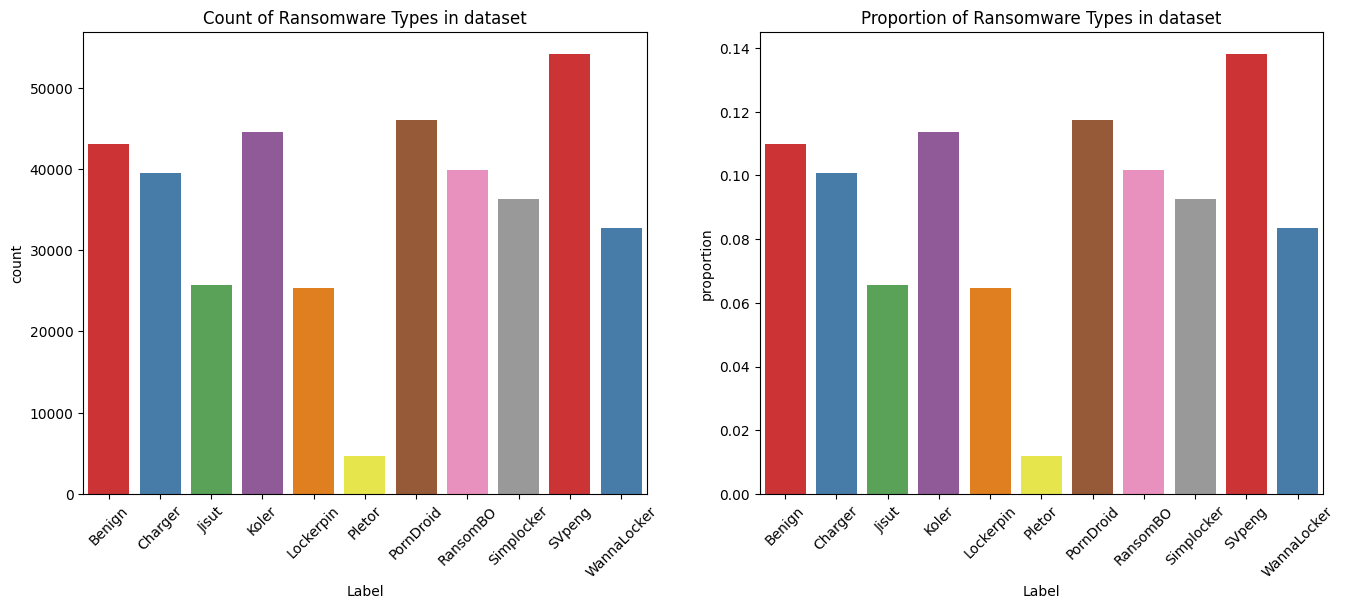

In [12]:
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[0], palette=ransomware_palette)
axes[0].set_title('Count of Ransomware Types in dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[1], stat='proportion', palette=ransomware_palette)
axes[1].set_title('Proportion of Ransomware Types in dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.show()

In [16]:
def is_private_ip(ip):
    try:
      ip_obj = ipaddress.ip_address(ip)

      if ip_obj.is_private:
          return 'private'
      elif ip_obj.is_loopback:
          return 'loopback'
      elif ip_obj.is_link_local:
          return 'link_local'
      elif ip_obj.is_multicast:
          return 'multicast'
      else:
          return 'public'
    except ValueError:
        return None

processed_ransomware_df['Source_IP_type'] = processed_ransomware_df['Source IP'].apply(is_private_ip)
processed_ransomware_df['Destination_IP_type'] = processed_ransomware_df['Destination IP'].apply(is_private_ip)

summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df[['Source_IP_type', 'Destination_IP_type']]))
display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

,Column,Data Type,Total Count,Total Distinct,Null Count,Mode
0,Source_IP_type,object,392034,2,0,private
1,Destination_IP_type,object,392034,3,0,public


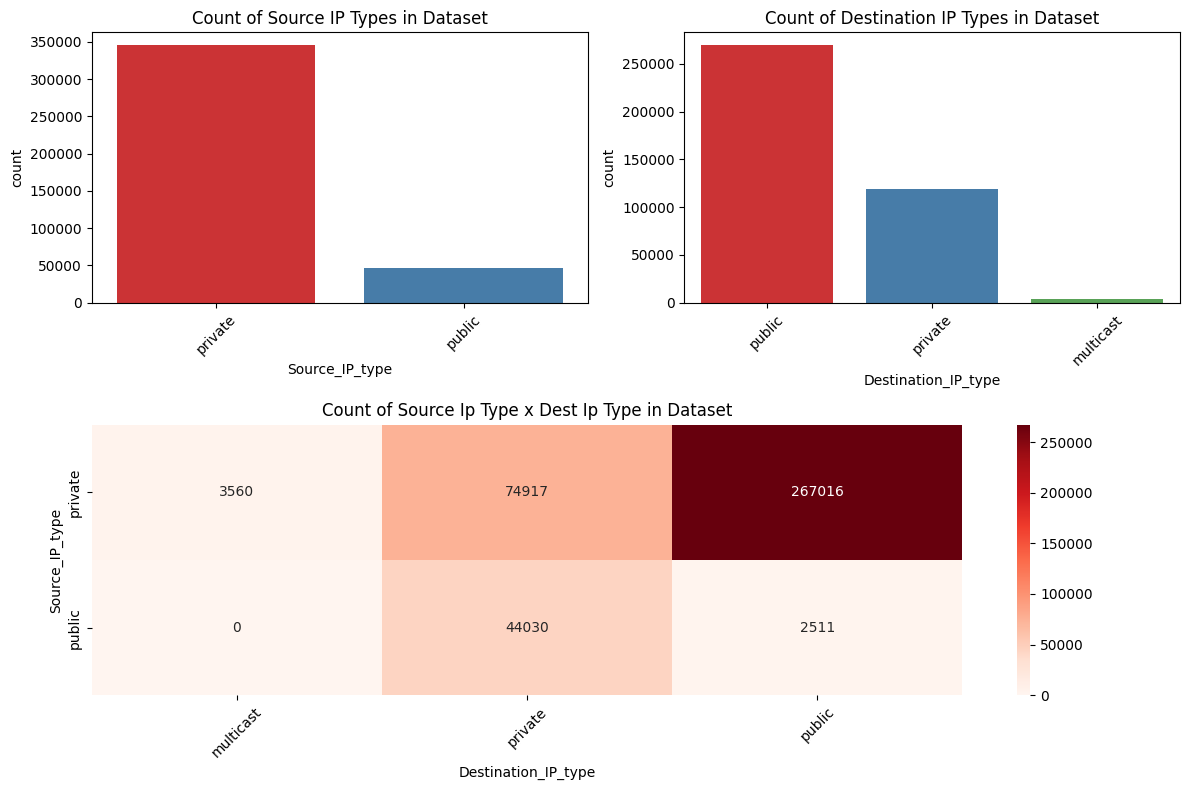

In [17]:
# Define figure and gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Top-left plot
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(data=processed_ransomware_df, x='Source_IP_type', ax=ax1, palette=ransomware_palette)
ax1.set_title('Count of Source IP Types in Dataset')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Top-right plot
ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(data=processed_ransomware_df, x='Destination_IP_type', ax=ax2, palette=ransomware_palette)
ax2.set_title('Count of Destination IP Types in Dataset')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Bottom-wide plot, spanning both columns
ax3 = fig.add_subplot(gs[1, :])
contingency_table = pd.crosstab(processed_ransomware_df['Source_IP_type'], processed_ransomware_df['Destination_IP_type'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Reds', ax=ax3)

ax3.set_title('Count of Source Ip Type x Dest Ip Type in Dataset')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [27]:
def chi2_calculator( col1, col2):
  # Calculate the Chi-square statistic
    chi2 = 0
    contingency_table = pd.crosstab(col1, col2)


    n = contingency_table.sum().sum()  # Total number of observations

    # Calculate expected frequencies
    row_totals = contingency_table.sum(axis=1).values.reshape(-1, 1)
    col_totals = contingency_table.sum(axis=0).values.reshape(1, -1)
    expected = (row_totals @ col_totals) / n  # Expected frequency for each cell



    # Compute Chi-square by summing (Observed - Expected)^2 / Expected
    chi2 = ((contingency_table - expected) ** 2 / expected).to_numpy().sum()

    return chi2, (row_totals.shape[0]-1)*(col_totals.shape[1]-1) # returns chi2, degree for freedom (r-1)*(c-1)

#Corrected Cramers https://stats.lse.ac.uk/bergsma/pdf/cramerV3.pdf
def cramers_v(col1, col2):

    # Step 1: Create a contingency table
    contingency_table = pd.crosstab(col1, col2)
    n = contingency_table.sum().sum()
    # Step 2: Calculate the Chi-square statistic
    chi2, chi_df = chi2_calculator(col1, col2)
    phi2 = chi2 / n

    r, c = contingency_table.shape
    #corrected phi2
    phi2 = max(0, phi2 - ((c-1)*(r-1)/(n-1)))

    r = r - ((r -1)**2/(n-1))
    c = c - ((c -1)**2/(n-1))


    # Step 3: Calculate Cramér's V

    cramers_v = np.sqrt(phi2 / (min(r-1, c-1)))

    return cramers_v

In [28]:
#cramer v for source port and label

sample_df = processed_ransomware_df[['Source Port', 'Label']]  # Adjust 'n' as needed
cvalue_s_port_label = cramers_v(sample_df['Source Port'], sample_df['Label'])
print("cramers v  for source_port and label = ", cvalue_s_port_label)

#cramers v for destination port and label
sample_df = processed_ransomware_df[['Destination Port', 'Label']]  # Adjust 'n' as needed
cvalue_d_port_label = cramers_v(sample_df['Destination Port'], sample_df['Label'])
print("cramers v  for Destination port and label = ", cvalue_d_port_label)


#cramers v for source and destination port pair v label
sample_df = pd.DataFrame()

sample_df['Source_Destination_port'] = processed_ransomware_df['Source Port'].astype(str) + '-' + processed_ransomware_df['Destination Port'].astype(str)
sample_df['Label'] = processed_ransomware_df['Label']
cvalue_s_d_port_label = cramers_v(sample_df['Source_Destination_port'], sample_df['Label'] )
print("cramers v  for Source-Destination port and label = ", cvalue_s_d_port_label)

#cramer v for source and destination port // Computationally too heavy

# sample_df = processed_ransomware_df[['Destination Port', 'Source Port']].sample(50000, random_state=42)
# # contingency_table = pd.crosstab(sample_df['col1'], sample_df['col2'])
# cvalue_sd_port_label = cramers_v(sample_df['Destination Port'], sample_df['Source Port'])
# print("cramers v  for Destination port and Source Port = ", cvalue_sd_port_label)

cramers v  for source_port and label =  0.28716033347813036
cramers v  for Destination port and label =  0.1975902954430126
cramers v  for Source-Destination port and label =  0.41845675289081613


### Observation

- Source Port and Ransomware Type has ~0.29 association; **Weak to Moderate** association

- Destination Port and Ransomware Type has ~0.19 association: **Weak** association

- Source-Destination Port Pair and Ransomware Type has ~0.42 assocition: **Moderate** associtation

Based on this we cannot drop the port table, as they have moderate assocation with ransomware type , when taken pair wise,  we may need further analysis, to drop the columns.

In [32]:
protocol_mapping = {
    0: 'Reserved',
    1: 'ICMP',              # Internet Control Message Protocol
    6: 'TCP',               # Transmission Control Protocol
    17: 'UDP',              # User Datagram Protocol
}

# Map protocol numbers to protocol names
processed_ransomware_df['Protocol'] = processed_ransomware_df['Protocol'].map(protocol_mapping)

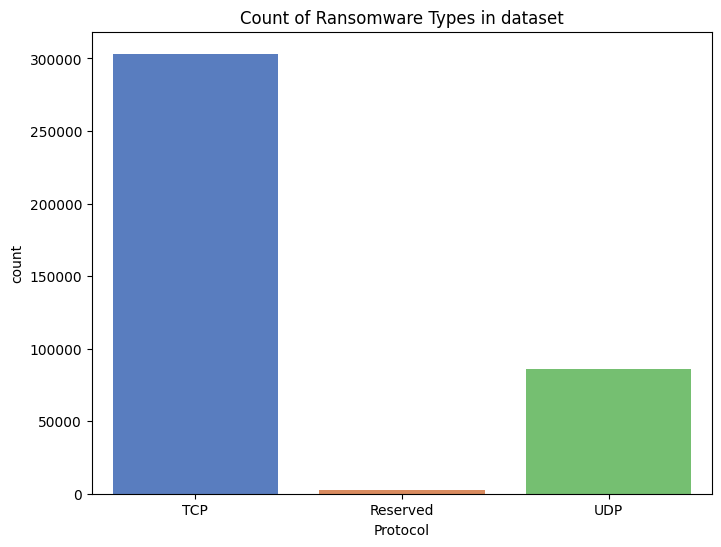

In [36]:
plt.figure(figsize=(8, 6))
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Protocol', palette=protocol_palette)
plt.title('Count of Ransomware Types in dataset')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
plt.show()

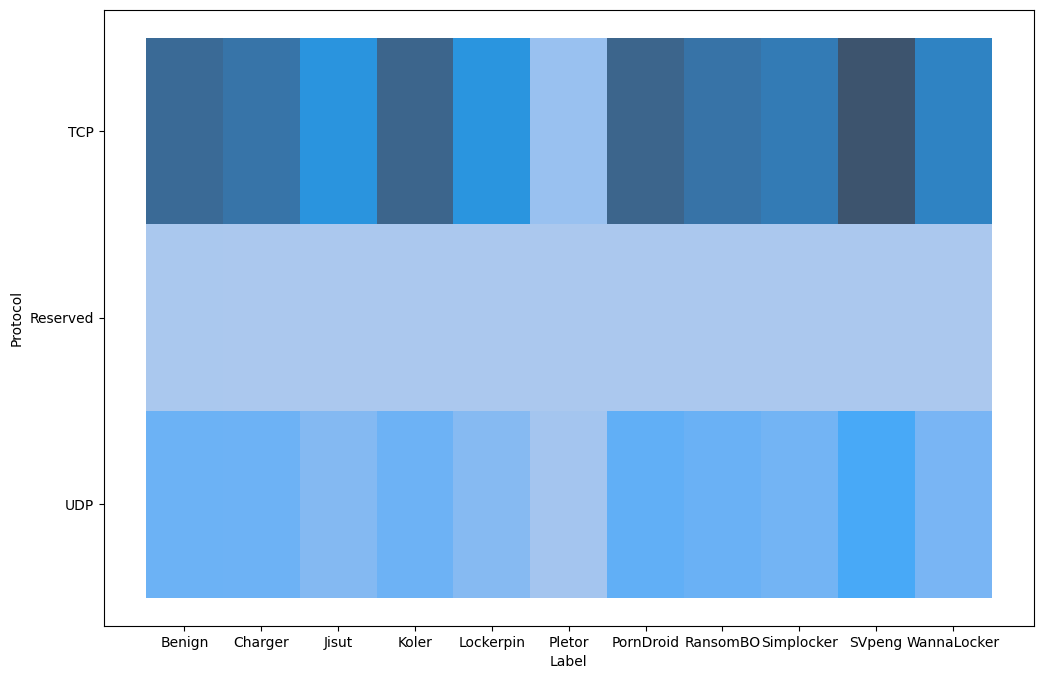

In [43]:
plt.figure(figsize=(12, 8))

sns.histplot(data=processed_ransomware_df, y='Protocol', x ='Label')
plt.show()

In [31]:
plt.figure(figsize=(12, 8))
grid = sn.FacetGrid(data=day_df_mod, col='cluster',height=3, aspect=1.2, col_wrap=4)

grid.map(sn.countplot,'mnth', 'cnt', order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], palette = month_palette)

# # grid.fig.suptitle('Count of Each Weekday in Each Cluster', y=1.05, fontsize=16

for i, ax in enumerate(grid.axes.flat):
  if i>3:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()
grid.fig.subplots_adjust(hspace=0.3, wspace=0.2)
grid.fig.suptitle('Distribution of Rides per Month in Each Cluster', y=1.05, fontsize=16)
# Show the plot
plt.show()

KeyError: 'protocols'